In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
# 
BEV_SIZE = 400 # pixel
MAX_DIS = 60 # m

def xyz_2_uv(X, P2):
    '''
    Transform camera cooridiante(x,y,z) to image plane(u,v)
    '''
    x,y,z = X
    X_img = np.matmul(P2, np.array([[x], [y], [z], [1]]))
    X_img /= X_img[2]
    u, v = int(X_img[0]), int(X_img[1])
    return (u,v)

def xz_2_bev_uv(X):
    x, z = X
    return (int(BEV_SIZE/2 + x*BEV_SIZE/MAX_DIS),
            int(BEV_SIZE   - z*BEV_SIZE/MAX_DIS))

def uv_2_xyz(X, P2, y0=1.65):
    P2_3x3 = np.array([P2[0, :3], P2[1, :3], P2[2, :3]])
    P2_inv = np.linalg.inv(P2_3x3)

    alpha = y0/( P2_inv[1,0]*X[0] + P2_inv[1,1]*X[1] + P2_inv[1,2] )
    
    ans = np.matmul(P2_inv, np.array([ [X[0]*alpha], [X[1]*alpha], [alpha]]))
    return (ans[0][0], ans[1][0], ans[2][0])

def get_slope(uv, P2, reso = (375, 1242)):
    MAX_SLOPE = 500

    # Remap uv to (375, 1242)
    uv = (uv[0]*1242/reso[1], uv[1]*375/reso[0])
    
    x, y, z = uv_2_xyz(uv, P2)
    u1, v1 = xyz_2_uv((x, y, z-10), P2)
    u2, v2 = xyz_2_uv((x, y, z+10), P2)
    
    # Avoid ZeroDivision
    if (u2-u1) == 0 : return MAX_SLOPE
    
    slope = (v2 - v1) / (u2 - u1)
    
    if slope > MAX_SLOPE: 
        return MAX_SLOPE
    elif slope < -MAX_SLOPE:
        return -MAX_SLOPE
    else:
        return slope


Img.shape = (375, 1242, 3)
bottom center = (600, 203)
bottom center = (612, 195)
bottom center = (1033, 405)
bottom center = (796, 284)
bottom center = (755, 244)
bottom center = (683, 209)
bottom center = (143, 281)
bottom center = (322, 237)
bottom center = (649, 190)


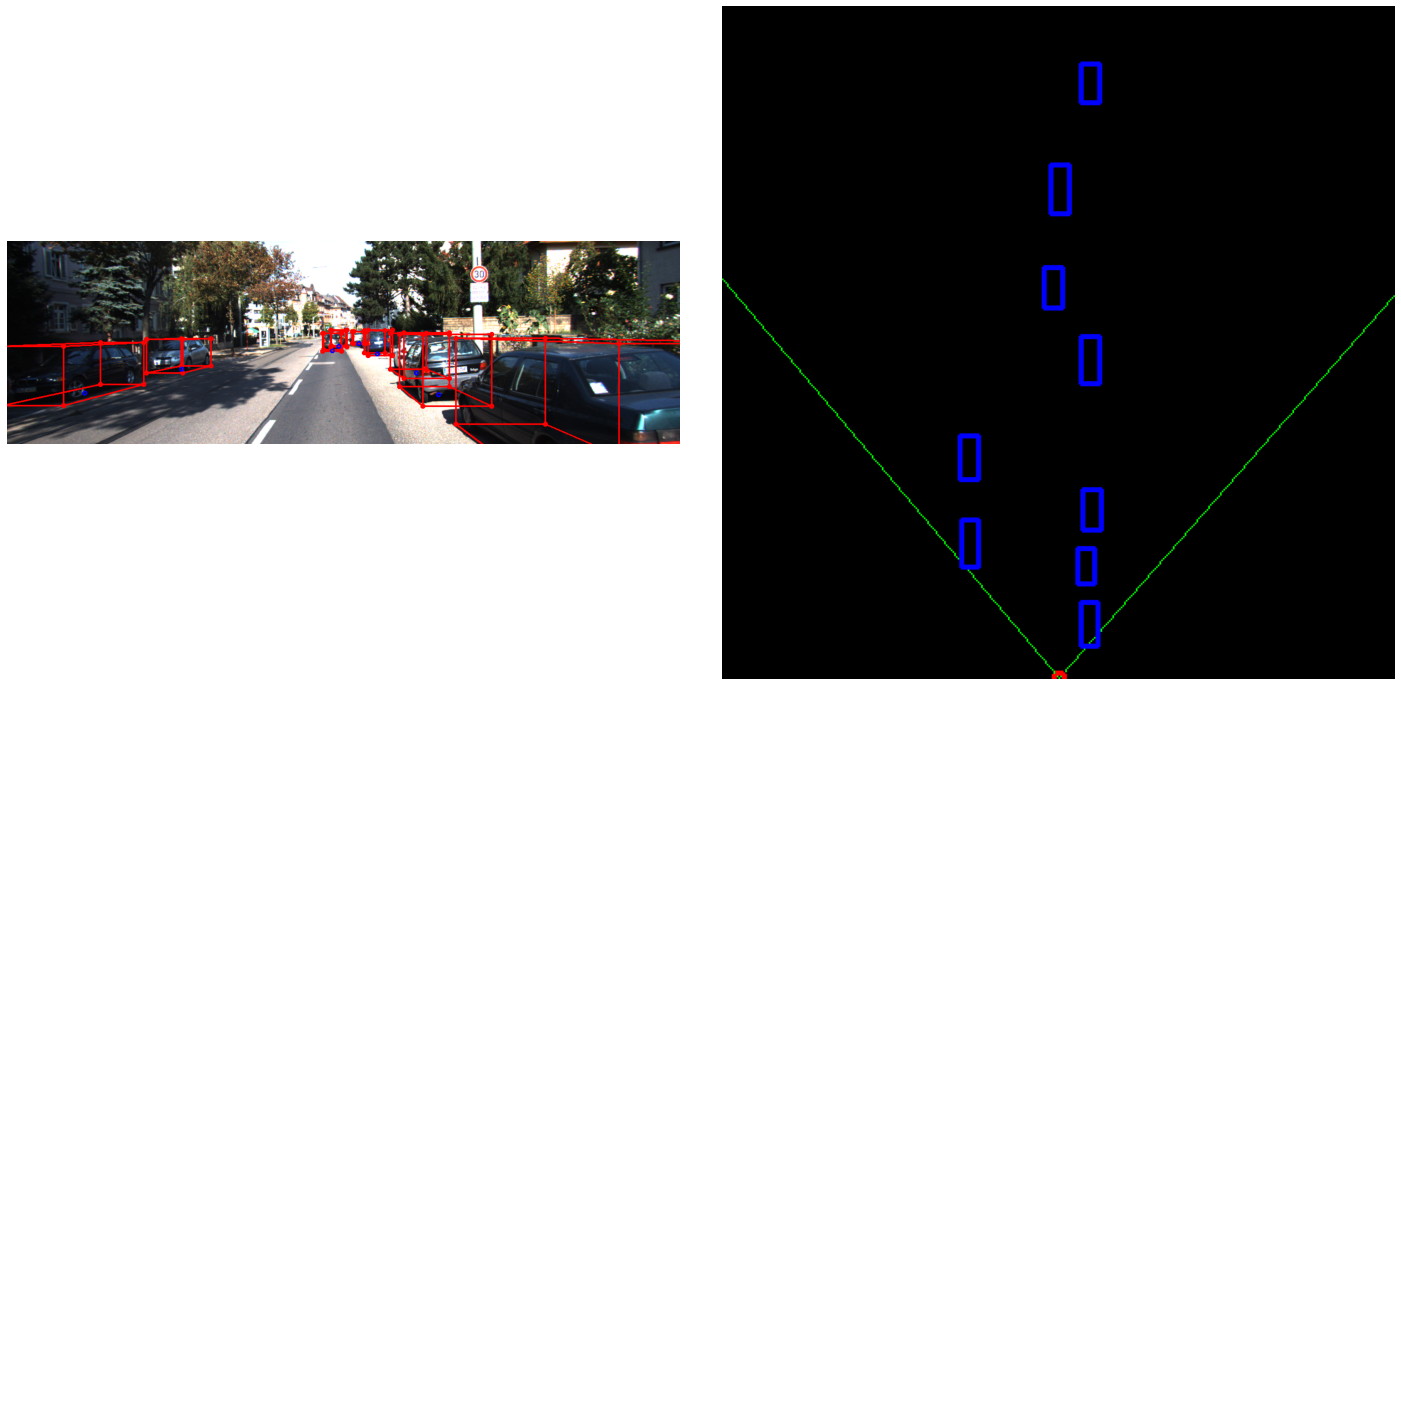

In [2]:
#    1    type         Describes the type of object: 'Car', 'Van', 'Truck',
#                      'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
#                      'Misc' or 'DontCare'
#    1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
#                      truncated refers to the object leaving image boundaries
#    1    occluded     Integer (0,1,2,3) indicating occlusion state:
#                      0 = fully visible, 1 = partly occluded
#                      2 = largely occluded, 3 = unknown
#    1    alpha        Observation angle of object, ranging [-pi..pi]
#    4    bbox         2D bounding box of object in the image (0-based index):
#                      contains left, top, right, bottom pixel coordinates
#    3    dimensions   3D object dimensions: height, width, length (in meters)
#    3    location     3D object location x,y,z in camera coordinates (in meters)
#    1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
#    1    score        Only for results: Float, indicating confidence in
#                      detection, needed for p/r curves, higher is better.
# 
img = cv2.imread("000172.png")
img_bev = np.zeros((BEV_SIZE, BEV_SIZE, 3), dtype=np.uint8)
print(f"Img.shape = {img.shape}")
height, width, channel = img.shape
# 
with open("000172_calib.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'P2:' in line.split():
            P2 = np.array([float(i) for i in line.split()[1:]] )
            P2 = np.reshape(P2, (3,4))
            break

# Draw FOV boundary on BEV img
l_fov = np.array(uv_2_xyz((0,     height), P2))
r_fov = np.array(uv_2_xyz((width, height), P2))
l_fov *= 1000
r_fov *= 1000
u_l_fov, v_l_fov = xz_2_bev_uv( (l_fov[0], l_fov[2]) )
u_r_fov, v_r_fov = xz_2_bev_uv( (r_fov[0], r_fov[2]) )
img_bev = cv2.line(img_bev, (BEV_SIZE//2, BEV_SIZE-1), (u_l_fov, v_l_fov), (0, 255, 0), 1)
img_bev = cv2.line(img_bev, (BEV_SIZE//2, BEV_SIZE-1), (u_r_fov, v_r_fov), (0, 255, 0), 1)
# 
with open("000172.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        h, w, l = [ float(i) for i in line.split()[8:11] ]
        x, y, z = [ float(i) for i in line.split()[11:14] ] # (x,y,z) is the bottom center of the object
        
        corners = []
        for x_o, y_o, z_o in [(-w/2, 0, -l/2), (-w/2, 0, l/2), (w/2, 0, l/2), (w/2, 0, -l/2), 
                              (-w/2,-h, -l/2), (-w/2,-h, l/2), (w/2,-h, l/2), (w/2,-h, -l/2)]:
            corners.append( (x+x_o, y+y_o, z+z_o) )
        
        corners_uv = []
        for c in corners:
            corners_uv.append(xyz_2_uv(c, P2))
            
        # Draw Corner
        for c in corners_uv:
            img = cv2.circle(img, c, 3, (0, 0,255), 2)
        
        # Draw Corner's line
        for c_i, c_j in [(0,1), (1,2), (2,3), (3,0),
                         (4,5), (5,6), (6,7), (7,4),
                         (0,4), (1,5), (2,6), (3,7)]:        
            cv2.line(img, corners_uv[c_i], corners_uv[c_j], (0, 0, 255), 2)

        # Bottom Center
        X = np.array([[x], [y], [z], [1]])
        X_img = np.matmul(P2, X)
        X_img /= X_img[2]
        u, v = int(X_img[0]), int(X_img[1])
        img = cv2.circle(img, (u, v), 3, (255, 0,0), 2)
        print(f"bottom center = {(u, v)}")

        # Draw BEV original
        img_bev = cv2.circle(img_bev, (BEV_SIZE//2, BEV_SIZE-1), 3, (255, 0,0), 2)
        # Draw BEV
        for c_i, c_j in [(0,1), (1,2), (2,3), (3,0)]:
            xi, yi, zi = corners[c_i]
            xj, yj, zj = corners[c_j]
            ui, vi = xz_2_bev_uv((xi, zi)) # int(BEV_SIZE/2 + xi*BEV_SIZE/MAX_DIS), int(BEV_SIZE - zi*BEV_SIZE/MAX_DIS)
            uj, vj = xz_2_bev_uv((xj, zj))# int(BEV_SIZE/2 + xj*BEV_SIZE/MAX_DIS), int(BEV_SIZE - zj*BEV_SIZE/MAX_DIS)
            img_bev = cv2.line(img_bev, (ui, vi), (uj, vj), (0, 0, 255), 2)

# BGR to RGB
img = img[...,::-1].copy()

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')
fig.tight_layout()
[b.axis('off') for a in ax for b in a ]# Delete all axis
# 
ax[0, 0].imshow(img)
ax[0, 1].imshow(img_bev)


# Draw staight line 

Img.shape = (375, 1242, 3)


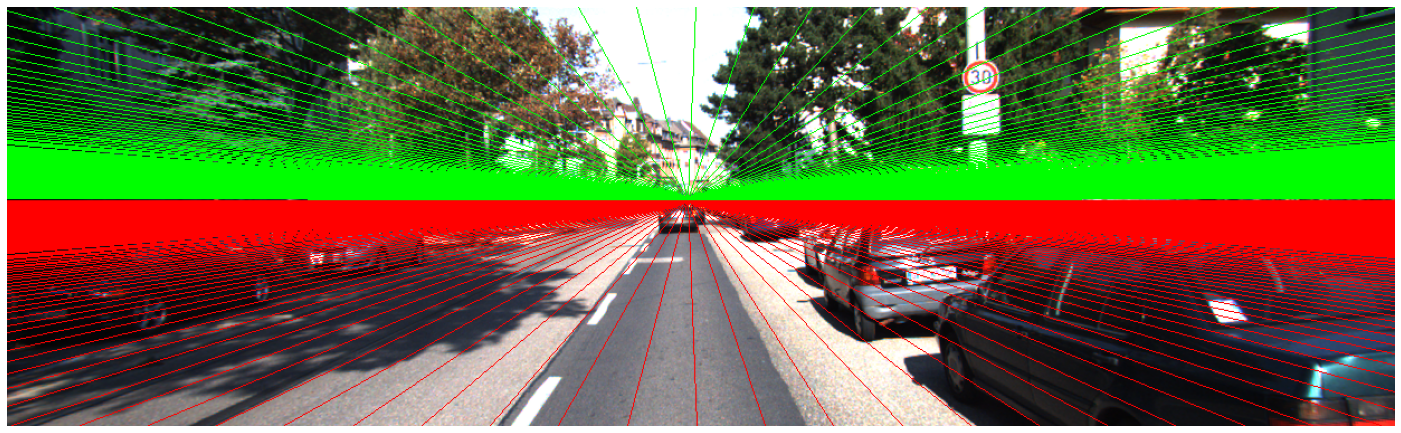

In [3]:
MAX_WIDTH_LINE = 1000
CAMERA_ELEVATION = 1.65 # 1.65

img = cv2.imread("000172.png")
print(f"Img.shape = {img.shape}")
height, width, channel = img.shape
# 
with open("000172_calib.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'P2:' in line.split():
            P2 = np.array([float(i) for i in line.split()[1:]] )
            P2 = np.reshape(P2, (3,4))
            break

# Reference: http://www.cvlibs.net/datasets/kitti/setup.php # Camera height: 1.65m

# Draw depth line (lower)
for x in np.arange(-MAX_WIDTH_LINE, MAX_WIDTH_LINE, 0.5):
    img = cv2.line(img, xyz_2_uv((x, CAMERA_ELEVATION, 0), P2), xyz_2_uv((x, CAMERA_ELEVATION, 10000), P2), (0, 0, 255), 1)
# Draw depth line (high)
for x in np.arange(-MAX_WIDTH_LINE, MAX_WIDTH_LINE, 0.5):
    img = cv2.line(img, xyz_2_uv((x, -CAMERA_ELEVATION, 0), P2), xyz_2_uv((x, -CAMERA_ELEVATION, 10000), P2), (0, 255, 0), 1)


# # Draw crab line
# for x in np.arange(0, 10, 0.5):
#     img = cv2.line(img, xyz_2_uv((0, 1.65, 0), P2), xyz_2_uv((x, 1.65, 10000), P2), (255, 0, 0), 1)

# BGR to RGB
img = img[...,::-1].copy()

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig.set_facecolor('white')
fig.tight_layout()
ax.axis('off')
ax.imshow(img)



# IPM (Inverse Perspective Mapping)

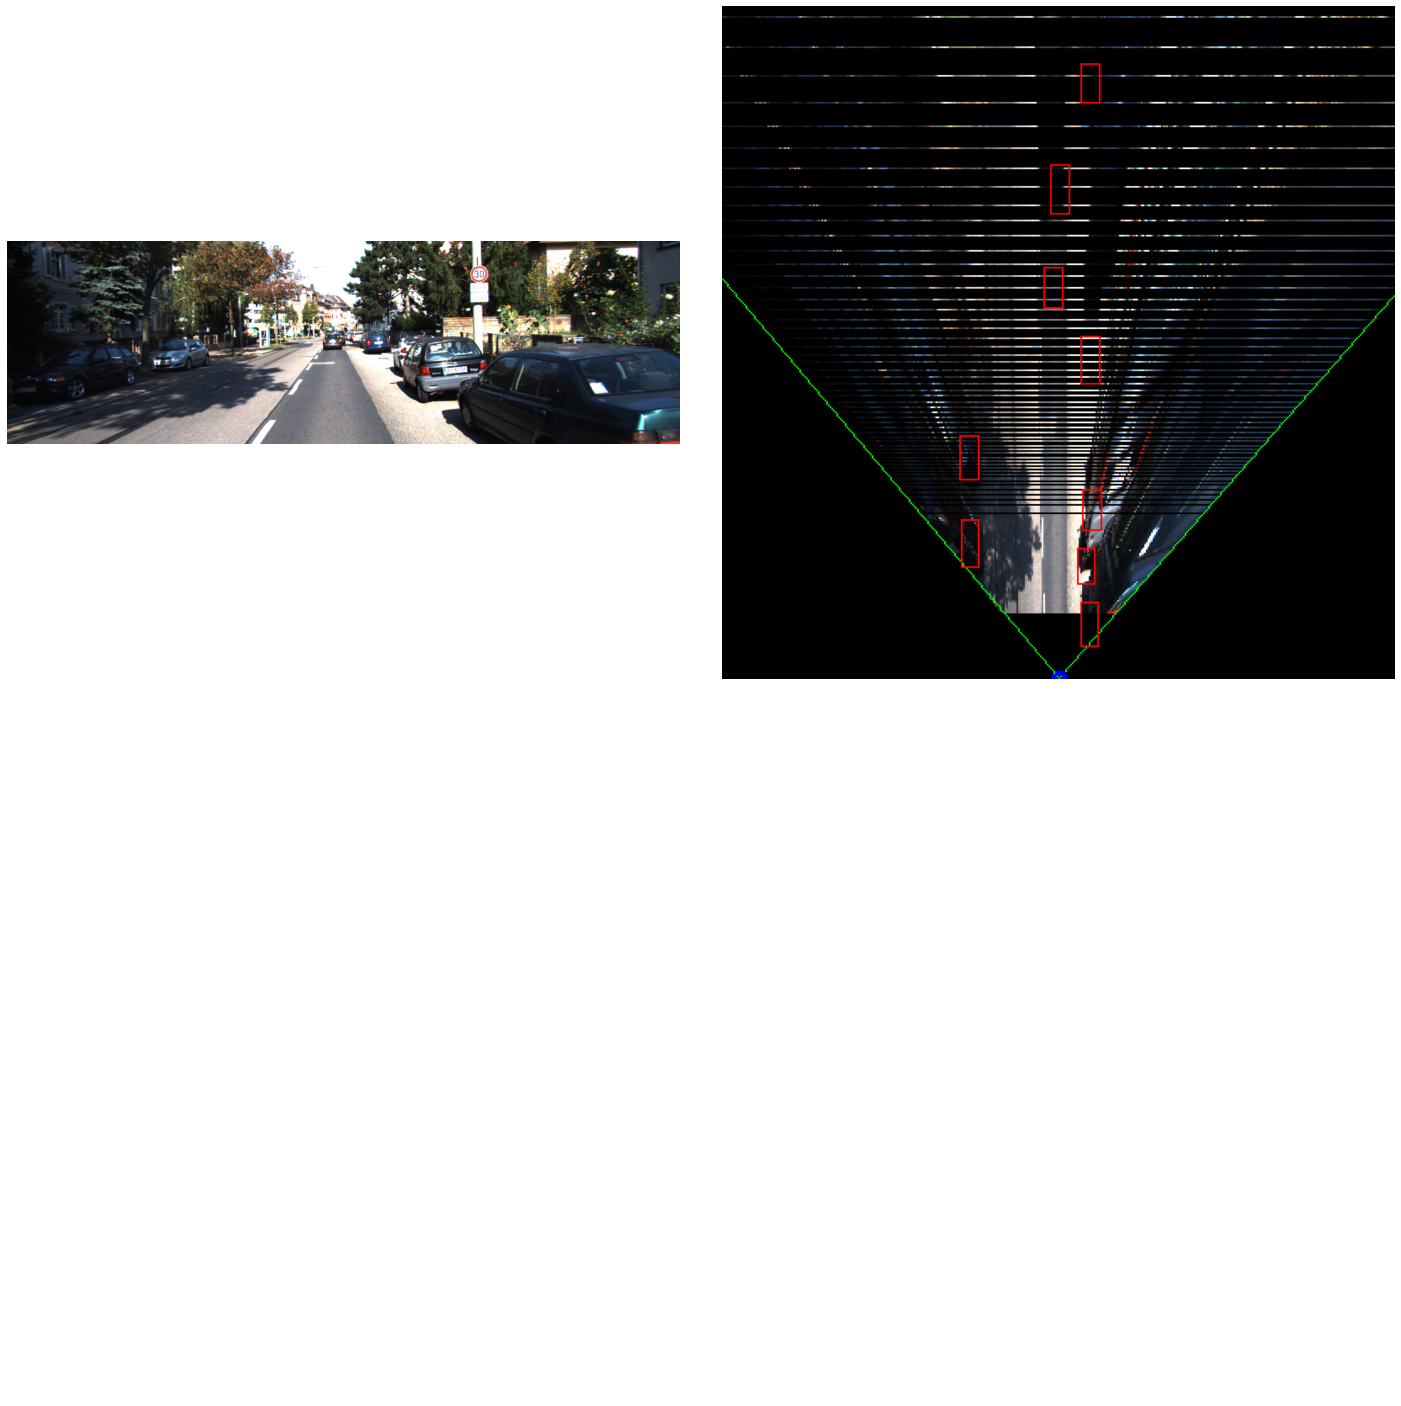

In [4]:
img = cv2.imread("000172.png")
img_bev = np.zeros((BEV_SIZE, BEV_SIZE, 3), dtype=np.uint8)

# My homography
for v in range(img.shape[0]):
    for u in range(img.shape[1]):
        x, y, z = uv_2_xyz((u, v), P2, 1.65)
        u_bev, v_bev = xz_2_bev_uv((x, z))
        if u_bev >= 0 and v_bev >= 0:
            try:
                img_bev[v_bev, u_bev] = img[v, u]
            except IndexError:
                pass

# Opencv2 homography
# pts_src = np.array([[0, 300], [1241, 300], [0, 350],[1241, 350]])
# pts_dst = []
# for pts in pts_src:
#     x, y, z = uv_2_xyz((u, v), P2)
#     u_bev, v_bev = xz_2_bev_uv((x/y, z/y))
#     pts_dst.append( [u_bev, v_bev] )
# pts_dst = np.array(pts_dst)
# h, status = cv2.findHomography(pts_src, pts_dst)
# img_bev    = cv2.warpPerspective(img, h, (BEV_SIZE, BEV_SIZE))

# Draw FOV boundary on BEV img
l_fov = np.array(uv_2_xyz((0,       height), P2))
r_fov = np.array(uv_2_xyz((width-1, height), P2))
l_fov *= 1000 # Make boundary line very long
r_fov *= 1000
img_bev = cv2.line(img_bev, (BEV_SIZE//2, BEV_SIZE-1), xz_2_bev_uv( (l_fov[0], l_fov[2]) ), (0, 255, 0), 1)
img_bev = cv2.line(img_bev, (BEV_SIZE//2, BEV_SIZE-1), xz_2_bev_uv( (r_fov[0], r_fov[2]) ), (0, 255, 0), 1)

# 
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')
fig.tight_layout()
[b.axis('off') for a in ax for b in a ]# Delete all axis

# Draw ground true bounding-box
with open("000172.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        h, w, l = [ float(i) for i in line.split()[8 :11] ]
        x, y, z = [ float(i) for i in line.split()[11:14] ] # (x,y,z) is the bottom center of the object
        
        corners = []
        for x_o, z_o in [(-w/2, -l/2), (-w/2, l/2), (w/2, l/2), (w/2, -l/2)]:
            corners.append( (x+x_o, z+z_o) )
        
        # Draw Camera cooridiante origin on BEV img
        img_bev = cv2.circle(img_bev, (BEV_SIZE//2, BEV_SIZE-1), 3, (255, 0,0), 2)
        
        # Draw Bottom Center
        # img_bev = cv2.circle(img_bev, xz_2_bev_uv((x, z)), 2, (255, 0,0), 1)
        # u, v = xz_2_bev_uv((x, z))

        # Draw Boudning box on BEV
        for c_i, c_j in [(0,1), (1,2), (2,3), (3,0)]:
            xi, zi = corners[c_i]
            xj, zj = corners[c_j]
            ui, vi = xz_2_bev_uv((xi, zi))
            uj, vj = xz_2_bev_uv((xj, zj))
            img_bev = cv2.line(img_bev, (ui, vi), (uj, vj), (0, 0, 255), 1)

# 
img = img[...,::-1].copy()
img_bev = img_bev[...,::-1].copy()
# 
ax[0, 0].imshow(img)
ax[0, 1].imshow(img_bev)




## CoordConv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1394.0717
-6888.855
8154.3643
7136.145


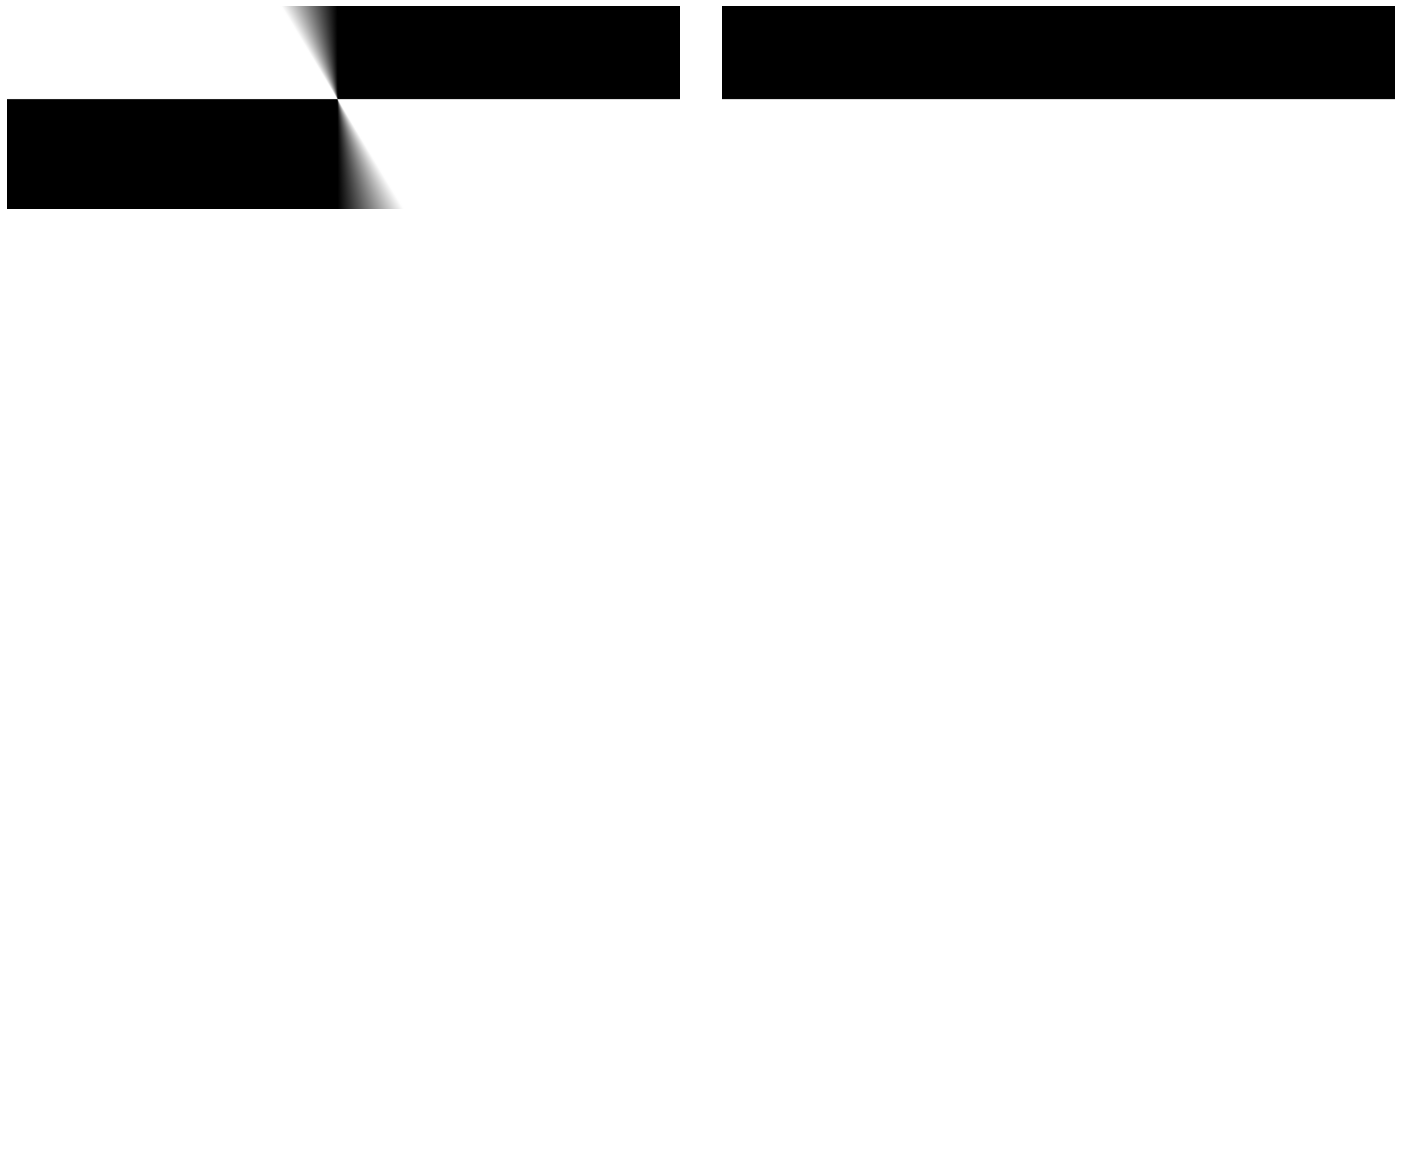

In [5]:
img = cv2.imread("000172.png")
img_x = np.zeros(img.shape, dtype=np.float32)
img_z = np.zeros(img.shape, dtype=np.float32)

# My homography
for v in range(img.shape[0]):
    for u in range(img.shape[1]):
        x, y, z = uv_2_xyz((u, v), P2, 1.65)
        # u_bev, v_bev = xz_2_bev_uv((x, z))
        img_x[v, u] = x
        img_z[v, u] = z
# 
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')
fig.tight_layout()
[b.axis('off') for a in ax for b in a ] # Delete all axis
# 

# img_x_norm = cv2.normalize(img_x, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# print(img_x_norm)

ax[0, 0].imshow(img_x)
ax[0, 1].imshow(img_z)
# print(img_z)
# print(img_x)
print(img_z.min())
print(img_x.min())
print(img_z.max())
print(img_x.max())



## WGAC test


Img.shape = (375, 1242, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


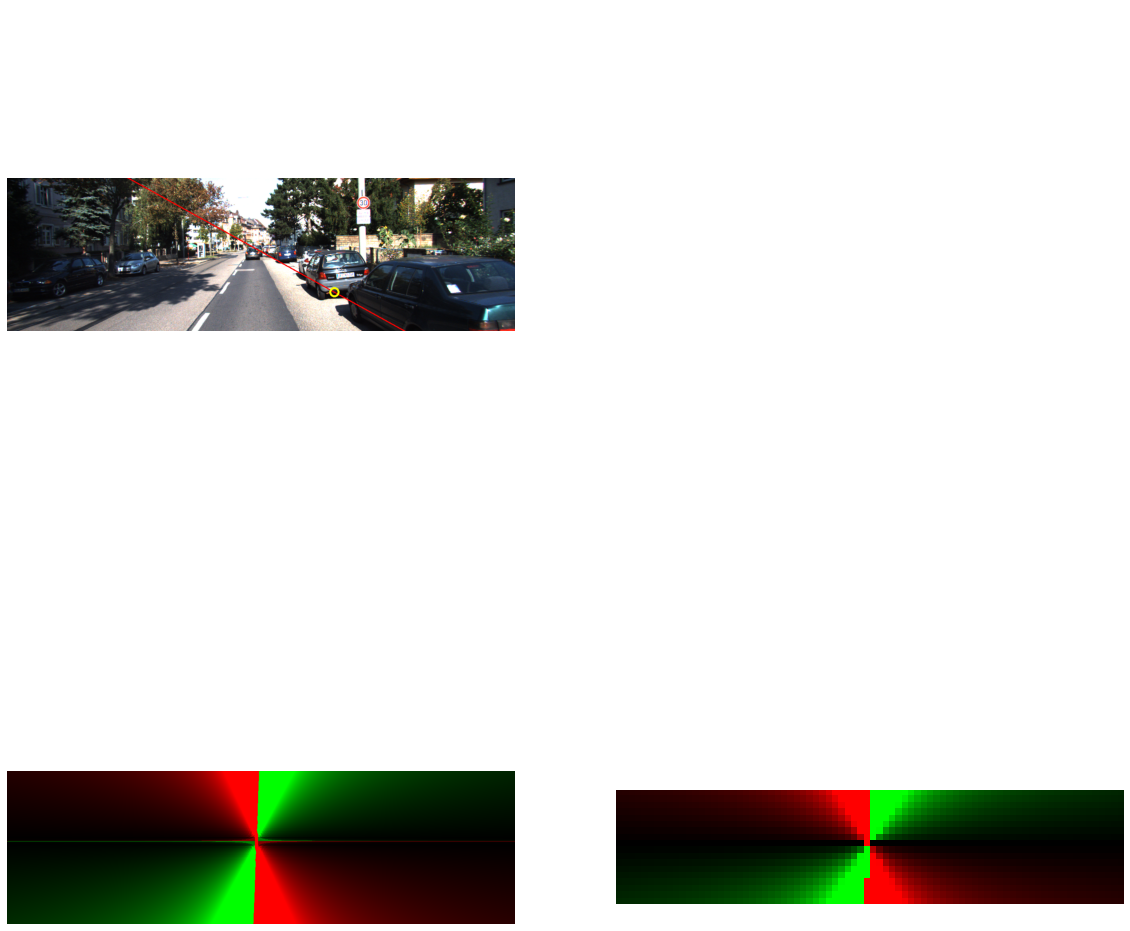

In [12]:
CAMERA_ELEVATION = 1.65 # 1.65
input_uv = (800, 280)
SMALL_RESO = (18, 80, 3)

img = cv2.imread("000172.png")
img_slope = np.zeros(img.shape, dtype=np.float32)
img_slope_small = np.zeros(SMALL_RESO, dtype=np.float32)

print(f"Img.shape = {img.shape}")
height, width, channel = img.shape
# 
with open("000172_calib.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'P2:' in line.split():
            P2 = np.array([float(i) for i in line.split()[1:]] )
            P2 = np.reshape(P2, (3,4))
            break

slope = get_slope(input_uv, P2)

OFFSET = 100000
img = cv2.line(img, 
               (input_uv[0] + OFFSET, int(input_uv[1] + OFFSET*slope)),
               (input_uv[0] - OFFSET, int(input_uv[1] - OFFSET*slope)),
               (0, 0, 255), 
               2)

# Draw input pixel
img = cv2.circle(img, (input_uv), 10, (0, 255,255), 4)

# Draw image slope
for v in range(img.shape[0]):
    for u in range(img.shape[1]):
        slope = get_slope((u, v), P2)
        if slope >= 0: # Positive number
            img_slope[v, u, 0] = slope
        else:
            img_slope[v, u, 1] = abs(slope)

# Draw image_small resolution slope
for v in range(SMALL_RESO[0]):
    for u in range(SMALL_RESO[1]):
        slope = get_slope((u, v), P2, SMALL_RESO)
        if slope >= 0: # Positive number
            img_slope_small[v, u, 0] = slope
        else:
            img_slope_small[v, u, 1] = abs(slope)

img_slope_small = cv2.normalize(img_slope_small, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
img_slope = cv2.normalize(img_slope, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# BGR to RGB
img = img[...,::-1].copy()

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')
# fig.tight_layout()
[b.axis('off') for a in ax for b in a ] # Delete all axis

ax[0, 0].imshow(img)
ax[1, 0].imshow(img_slope)
ax[1, 1].imshow(img_slope_small)



## M3D-RPN anchor investigation 


conf.anchor_scales = [ 32.          40.1104343   50.27646685  63.01909126  78.99134748
  99.01178916 124.10643323 155.56134174 194.98853052 244.40858256
 306.35419975 384.        ]
conf.anchor_ratios = [0.5 1.  1.5]
conf.has_3d = True
conf.cluster_anchors = 0
16
(36, 9)
[[-5.00000000e-01 -8.50000000e+00  1.55000000e+01  2.35000000e+01
   5.21453775e+01  5.81754386e-01  1.72789474e+00  1.29666667e+00
   2.13853264e-01]
 [-8.50000000e+00 -8.50000000e+00  2.35000000e+01  2.35000000e+01
   5.18913304e+01  1.50147059e+00  1.61593137e+00  3.59274510e+00
  -5.05022635e-01]
 [-1.65000000e+01 -8.50000000e+00  3.15000000e+01  2.35000000e+01
   4.73391214e+01  1.64995074e+00  1.49743842e+00  3.92922824e+00
   3.57177540e-01]
 [-2.52760863e+00 -1.25552168e+01  1.75276089e+01  2.75552177e+01
   4.40955925e+01  5.88248175e-01  1.75547445e+00  1.11576642e+00
   6.47950460e-01]
 [-1.25552168e+01 -1.25552168e+01  2.75552177e+01  2.75552177e+01
   4.44565533e+01  1.58342495e+00  1.58610994e+00  3.652663

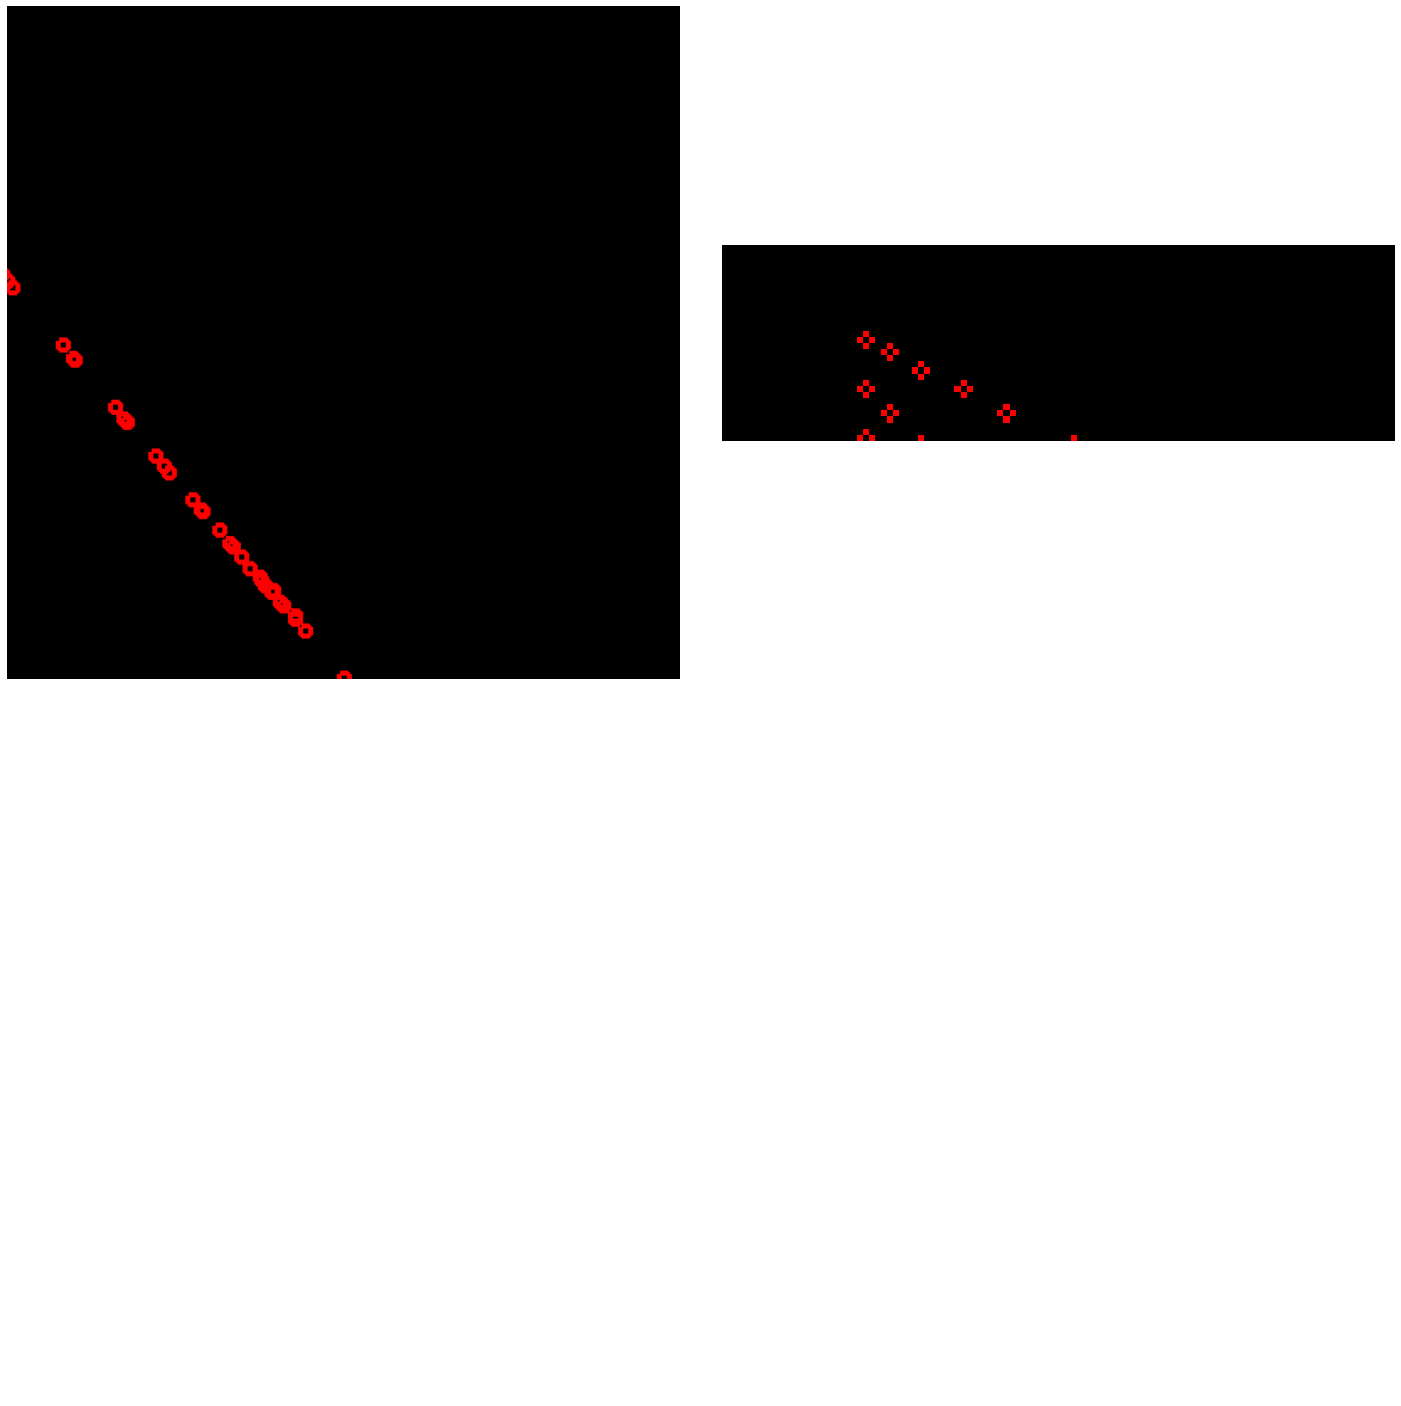

In [7]:
from easydict import EasyDict as edict
import pickle

def pickle_read(file_path):
    """
    De-serialize an object from a provided file_path
    """

    with open(file_path, 'rb') as file:
        return pickle.load(file)


conf_path = '/home/lab530/KenYu/M3D-RPN/M3D-RPN-Release/m3d_rpn_depth_aware_test_config.pkl'

conf = edict(pickle_read(conf_path))

img_bev = np.zeros((BEV_SIZE, BEV_SIZE, 3), dtype=np.uint8)
img_2d  = np.zeros((32, 110, 3), dtype=np.uint8)

# Draw BEV original
img_bev = cv2.circle(img_bev, (BEV_SIZE//2, BEV_SIZE-1), 3, (255, 0,0), 2)
# Draw BEV
for anchor in conf.anchors:
    w_2d, h_2d, u_p, v_p, z_p, w, h, l, r_y = anchor

    P2_3x3 = np.array([P2[0, :3], P2[1, :3], P2[2, :3]])
    P2_inv = np.linalg.inv(P2_3x3)
    ans = np.matmul(P2_inv, np.array([ [u_p], [v_p], [z_p]]))
    x_3d, y_3d, z_3d = ans[0][0], ans[1][0], ans[2][0]
    
    # Draw in img_2d
    img_2d = cv2.circle(img_2d, (int(v_p), int(u_p)), 1, (255, 0,0), 1)

    ui, vi = xz_2_bev_uv((x_3d, z_3d))
    # uj, vj = xz_2_bev_uv((xj, zj))# int(BEV_SIZE/2 + xj*BEV_SIZE/MAX_DIS), int(BEV_SIZE - zj*BEV_SIZE/MAX_DIS)
    img_bev = cv2.circle(img_bev, (ui, vi), 3, (255, 0,0), 2)

print(f"conf.anchor_scales = {conf.anchor_scales}")
print(f"conf.anchor_ratios = {conf.anchor_ratios}")
print(f"conf.has_3d = {conf.has_3d}")
print(f"conf.cluster_anchors = {conf.cluster_anchors}")

print(conf.feat_stride)
print(conf.anchors.shape)
print(conf.anchors)


fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')
fig.tight_layout()
[b.axis('off') for a in ax for b in a ]# Delete all axis
# 
ax[0, 0].imshow(img_bev)
# 
ax[0, 1].imshow(img_2d)


## GAC flow field investigation

torch.Size([1, 3, 288, 1280])
torch.Size([8, 18, 80, 2])
[-16.97056275  -8.48528137  16.97056275   8.48528137]
[-20.18151397 -10.09075698  20.18151397  10.09075698]
[-24. -12.  24.  12.]
[-28.54097076 -14.27048538  28.54097076  14.27048538]
[-33.9411255  -16.97056275  33.9411255   16.97056275]
[-40.36302793 -20.18151397  40.36302793  20.18151397]
[-48. -24.  48.  24.]
[-57.08194152 -28.54097076  57.08194152  28.54097076]
[-67.88225099 -33.9411255   67.88225099  33.9411255 ]
[-80.72605586 -40.36302793  80.72605586  40.36302793]
[-96. -48.  96.  48.]
[-114.16388304  -57.08194152  114.16388304   57.08194152]
[-135.76450199  -67.88225099  135.76450199   67.88225099]
[-161.45211173  -80.72605586  161.45211173   80.72605586]
[-192.  -96.  192.   96.]
[-228.32776608 -114.16388304  228.32776608  114.16388304]
[-12. -12.  12.  12.]
[-14.27048538 -14.27048538  14.27048538  14.27048538]
[-16.97056275 -16.97056275  16.97056275  16.97056275]
[-20.18151397 -20.18151397  20.18151397  20.18151397]
[-2

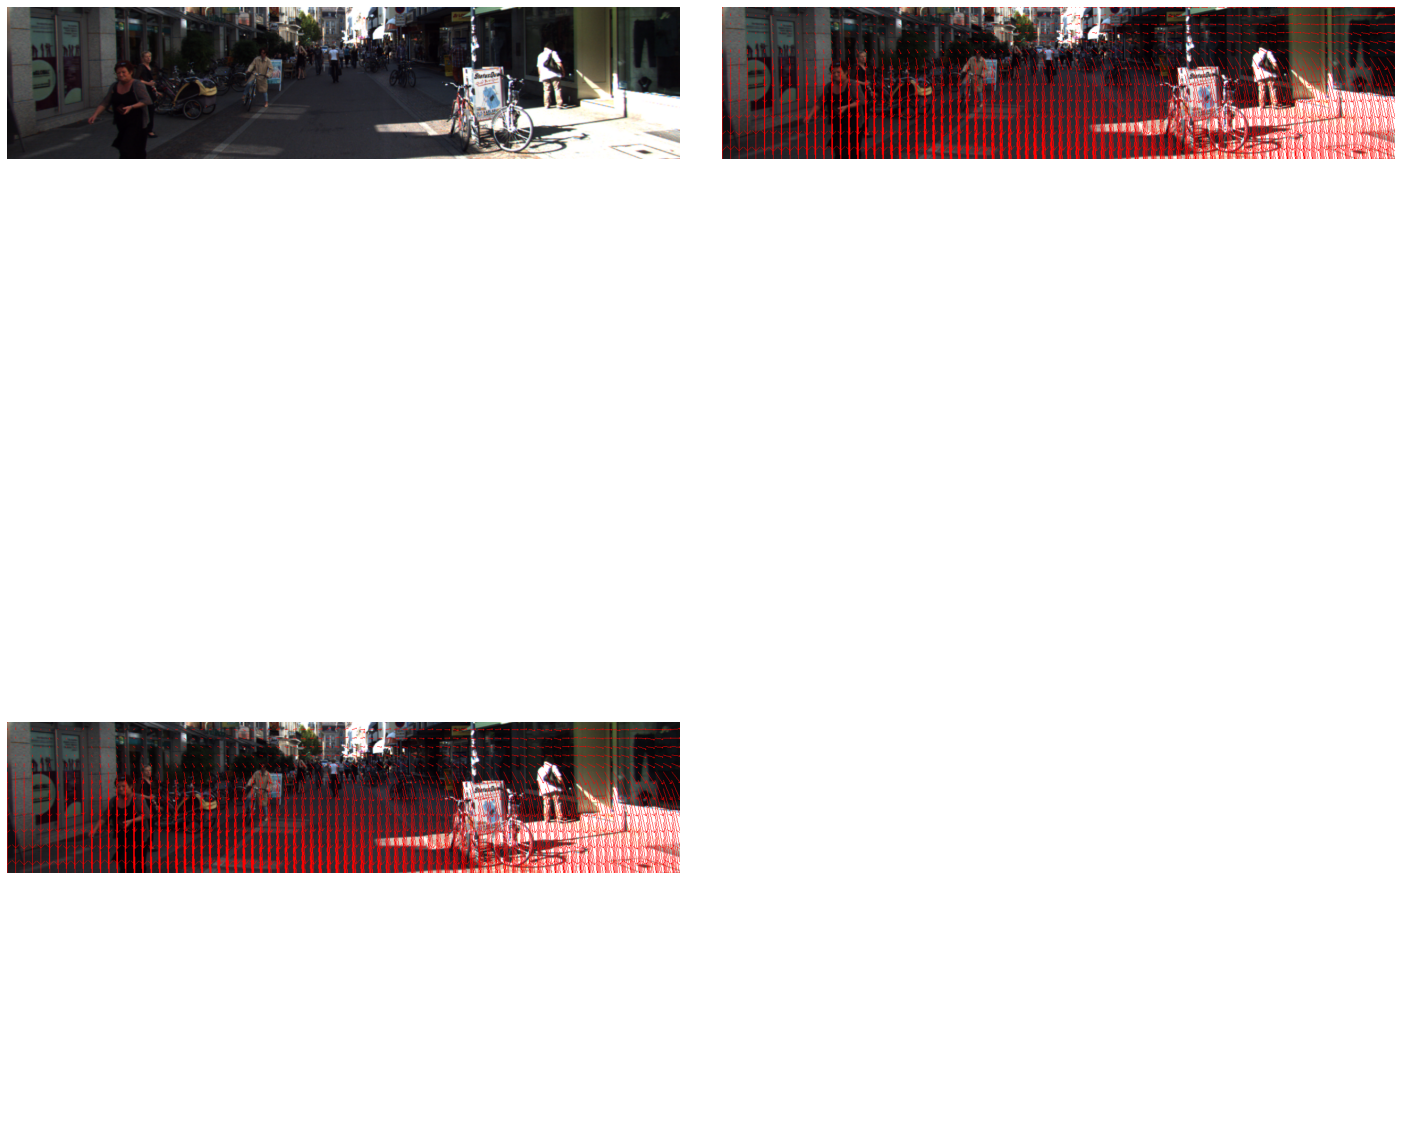

In [8]:
import pickle
from matplotlib import pyplot as plt
import torch
import torchvision.transforms as transforms
import cv2 
import numpy as np

unloader = transforms.ToPILImage() # [0.0, 1.0]
def to_image(o_tensor):
    o_img = o_tensor.cpu().clone()  # we clone the tensor to not do changes on it
    o_img = o_img.squeeze(0)  # remove the fake batch dimension
    o_img = torch.reshape(o_img, (3, 288, 1280))
    for c in range(3): # Normalize to [0, 1.0]
        x_min, x_max = o_img[c].min(), o_img[c].max()
        o_img[c] = (o_img[c] - x_min) / (x_max-x_min)
    o_img = unloader(o_img)
    return o_img


with open('/home/lab530/KenYu/visualDet3D/img_batch.pkl', 'rb') as f:
    img_batch = pickle.load(f)

with open('/home/lab530/KenYu/visualDet3D/flow_field.pkl', 'rb') as f:
    flow_field = pickle.load(f)

with open('/home/lab530/KenYu/visualDet3D/anchors.pkl', 'rb') as f:
    anchors = pickle.load(f)


print(img_batch.shape)
print(flow_field.shape)
flow_field = flow_field.cpu().detach().numpy()

# print(flow_field)

img_input = to_image(img_batch)

img_flow = img_input.copy()
img_flow = np.array(img_flow) 

# Draw img flow 
for row in range(18):
    for col in range(80):
        x, y = flow_field[0][row][col]
        img_flow = cv2.arrowedLine(img_flow, (int(col*16), int(row*16)), (int((x+1)*640), int((y+1)*144)), (255, 0, 0), 1)

# Draw ancor
img_anchor = img_input.copy()
img_anchor = np.array(img_anchor)
for anchor in anchors: 
    print(anchor)
    cv2.rectangle(img_anchor, (int(640+anchor[0]), int(144+anchor[1])), (int(640+anchor[2]), int(144+anchor[3])), (255, 0, 0), 1, cv2.LINE_AA)




fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')
fig.tight_layout()
[b.axis('off') for a in ax for b in a ]# Delete all axis
# 
ax[0, 0].imshow(img_input)
# 
ax[0, 1].imshow(img_flow)
# 
ax[1, 0].imshow(img_flow)

